In [41]:
import numpy as np, torch, matplotlib.pyplot as plt
import os
import sys

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, "../src"))

if module_path not in sys.path:
    sys.path.append(module_path)

dpo_path = '../src/best_dpo_policy.pth'

horizon = 500

Creating Path with step 3
Resetting environment. Previous state: [0.05 0.05], Counter: 0
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 0, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 1, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 2, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 3, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 4, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 5, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 6, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 7, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step called. Counter: 8, Horizon: 500
cur: -1.7367135286331177 max: -21.571148 min: -55.73801
Step call

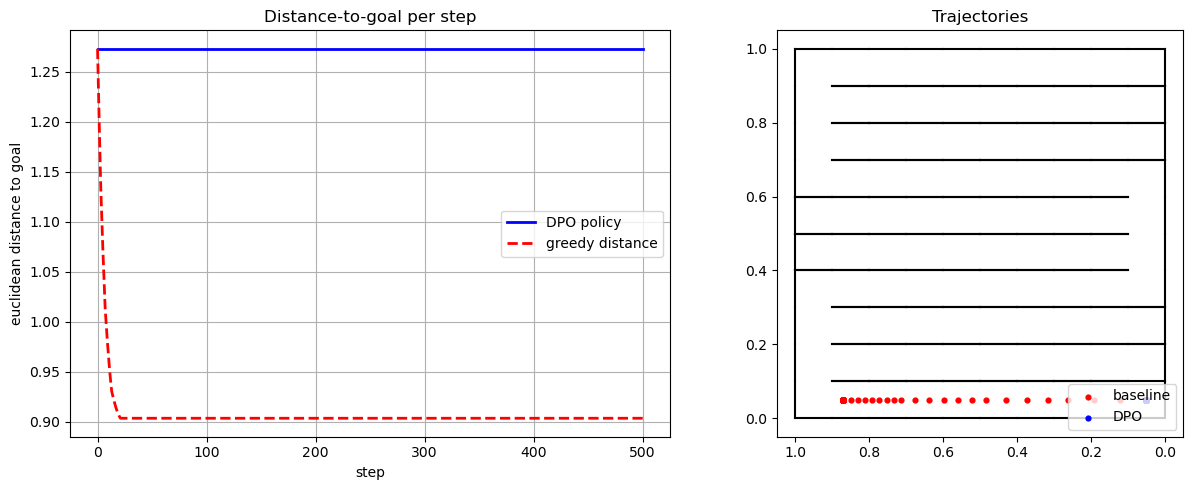

In [42]:
import numpy as np, torch, matplotlib.pyplot as plt
from maze import Maze
from maze_env import MazeEnv, draw_map
from maze_env import PolicyNetwork

# utils.py (o direttamente in make_comparison.ipynb)

def best_improving_action(env, acts, ref_metric, tol=1e-6):
    """
    Ritorna la prima azione che riduce di almeno `tol`
    il valore di ref_metric(s') rispetto a quello corrente.
    Se nessuna azione migliora, restituisce None.
    """
    best_a, best_val = None, ref_metric  # migliore finora (deve essere < ref)
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s1 = env.state + np.array([dx, dy])

        # qui usiamo la distanza al goal come metrica di riferimento
        val = np.linalg.norm(env.goal - s1)

        # opzionale: scarta subito se la mossa collide
        if env.point_collision(s1[0], s1[1]):
            continue

        if val < best_val - tol:
            best_val, best_a = val, a

    return best_a

# ------------------------------------------------------------------
# helper: rollout con politica arbitraria f(state) -> action
# ------------------------------------------------------------------
def rollout(env, policy_fn, max_steps=500):
    if max_steps is None:
        max_steps = env.horizon
    env.reset(state=start.copy())
    traj, dists = [env.state.copy()], [np.linalg.norm(env.goal-env.state)]
    for _ in range(max_steps):
        a = policy_fn(env)
        state, _, done, _, _ = env.step(a)
        traj.append(state.copy())
        dists.append(np.linalg.norm(env.goal - state))
        if done:
            break
    return np.array(traj), dists

def policy_dist_safe(env, tol=1e-6):
    acts = candidate_actions()
    cur_d = np.linalg.norm(env.goal - env.state)
    a = best_improving_action(env, acts, cur_d, tol=tol)
    return a if a is not None else np.zeros(2, dtype=np.float32)  # resta fermo

# ------------------------------------------------------------------
# 1. ambiente + DPO-policy caricata
# ------------------------------------------------------------------
hidden_dim = 128
num_layers = 4
dropout_prob = 0.05

start = np.array([0.05, 0.05])
maze  = Maze(10,10,0,0)
env_dpo = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                  reward="distance", dt=0.1, horizon=horizon, slide=1,
                  use_dpo=True, dpo_model_path=dpo_path, hidden_dim=hidden_dim, num_layers=num_layers, dropout_prob=dropout_prob)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#  --- costanti usate nel training ---
MEAN = torch.tensor([0.5, 0.5],  dtype=torch.float32, device=device)
STD  = torch.tensor([0.289, 0.289], dtype=torch.float32, device=device)

def _std(x: torch.Tensor) -> torch.Tensor:
    """centra e scala come nel training"""
    return (x - MEAN) / STD


# ------------------------------------------------------------------
# 2. definisci le due politiche
# ------------------------------------------------------------------
angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)  # 32 direzioni
speeds = [0.25, 0.5, 0.75, 1.0]                                    # 4 moduli                                   

def candidate_actions():
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

# -- DPO: valuta con la rete -----------------------
def policy_dpo(env):
    acts = candidate_actions()
    next_states = []
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        next_states.append(env.state + np.array([dx,dy]))
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    with torch.no_grad():
        scores = env.policy_net(next_states).cpu().numpy().squeeze()
    return acts[np.argmax(scores)]

def policy_dpo_safe(env, tol_val=0):
    """
    Accetta la prima azione (in ordine di score) che
    - non collide
    - fa crescere il valore DPO di almeno tol_val.
    Non guarda più la distanza euclidea.
    """
    acts = candidate_actions()

    # Valuta tutti i next-state con la rete
    next_states = []
    for a in acts:
        dx = a[0] * np.cos(a[1] * np.pi) * env.dt
        dy = a[0] * np.sin(a[1] * np.pi) * env.dt
        next_states.append(env.state + np.array([dx, dy]))

    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    next_states = _std(next_states)
    with torch.no_grad():
        scores = env.policy_net(next_states).cpu().numpy().squeeze()

    idx_sorted = np.argsort(scores)[::-1]           # dal migliore al peggiore
    cur_val    = env.evaluate_state_with_dpo(env.state)

    print("cur:", env.evaluate_state_with_dpo(env.state),
          "max:", scores.max(), "min:", scores.min())  # <— una sola volta

    for i in idx_sorted:
        a  = acts[i]
        s1 = next_states[i].detach().cpu().numpy()
        if env.point_collision(s1[0], s1[1]):
            continue                                # scarta se collide
        if scores[i] > cur_val + tol_val:  # tol_val ~1e-4 o adatta
            return a

    # se nessuna va bene → resta fermo
    return np.zeros(2, dtype=np.float32)



# -- baseline: minimizza distanza euclidea al goal --
def policy_dist(env):
    acts = candidate_actions()
    best, best_d = None, np.inf
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s  = env.state + np.array([dx,dy])
        d  = np.linalg.norm(env.goal - s)
        if d < best_d and not env.point_collision(s[0], s[1]):
            best_d, best = d, a
    return best if best is not None else acts[0]      # fallback

# ------------------------------------------------------------------
# 3. esegui i due roll-out
# ------------------------------------------------------------------
traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo_safe, max_steps=horizon)
# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo, max_steps=horizon)

#  per il baseline usiamo **una nuova copia** dell’ambiente (stesso maze!)
env_base = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                   reward="distance", dt=0.1, horizon=horizon, slide=1, use_dpo=False)
traj_base, dist_base = rollout(env_base, policy_dist_safe, max_steps=horizon)

# ------------------------------------------------------------------
# 4. plotting comparativo
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# --- distanza vs step
axes[0].plot(dist_dpo,  label="DPO policy",  lw=2, color='blue')
axes[0].plot(dist_base, label="greedy distance", lw=2, ls="--", color='red')
axes[0].set_xlabel("step")
axes[0].set_ylabel("euclidean distance to goal")
axes[0].set_title("Distance-to-goal per step")
axes[0].legend(); axes[0].grid(True)

# --- traiettorie
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)

# Traiettoria Baseline (greedy distance) con colore rosso solido
if len(traj_base) > 0:
    axes[1].scatter(traj_base[:,0], traj_base[:,1],
                    color="red",  # Modifica: colore rosso solido
                    s=12, label="baseline")
else:
    axes[1].scatter([],[], color="red", s=12, label="baseline") # Per la legenda se vuota

# Traiettoria DPO con colore blu solido
if len(traj_dpo) > 0:
    axes[1].scatter(traj_dpo[:,0], traj_dpo[:,1],
                    color="blue", # Modifica: colore blu solido
                    s=12, label="DPO")
else:
    axes[1].scatter([],[], color="blue", s=12, label="DPO") # Per la legenda se vuota


axes[1].invert_xaxis(); axes[1].set_aspect("equal")
axes[1].set_title("Trajectories")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [43]:
#  ▼ aggiungi/collega queste funzioni prima della policy_dpo ▼
def quick_sign_check(env, n=4000):
    """Restituisce la correlazione fra output di rete e total_score."""
    # 1) punti random (x,y) in (0,1)²
    pts = torch.rand((n,2), dtype=torch.float32, device=env.device)
    # 2) rete
    with torch.no_grad():
        r = env.policy_net(pts).cpu().numpy().ravel()
    # 3) total_score via il DataFrame già salvato
    import pandas as pd
    df = pd.read_parquet("positions.parquet")   # già normalizzato
    w_path, w_wall, w_goal, w_deg = 0.6, 0.15, 0.15, 0.15

    # --------------------------------------------------------
    # 4) score (minore è migliore)
    # --------------------------------------------------------
    df["total_score"] = (
        w_path * df.path_distance        #  + penalità: cammino lungo
        + w_goal * df.distance_to_goal        #  + penalità: lontano dal goal
        - w_deg  * df.degree         #  + penalità: vicolo cieco
        - w_wall * df.distance_from_wall        #  – bonus: punti “larghi”, lontani dai muri
    )
    df = df.sample(n, random_state=0)           # stessa numerosità
    s  = df.total_score.to_numpy()
    from scipy.stats import pearsonr
    return pearsonr(r, s)[0]                    # coefficiente di corr

corr = quick_sign_check(env_dpo)
print("corr =", corr)


corr = -0.0028616731088278815
